# The Sniff! - Lab - **Answers**

In this assignment we take on chemotaxic exploration. We'll compare two of our random agents, levy and diffusion, with a gradient searcher who operates akin to a _E. Coli_ (the simple model, anyway).

There are two sections. First we examine exploration for a single target with a variable scent in an open field. Second, we play with a maze.

## Install and import needed modules

In [ ]:
# # Install explorationlib?
# !pip install --upgrade git+https://github.com/parenthetical-e/explorationlib
# !pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

In [1]:
# Import misc
import shutil
import glob
import os
import copy
import sys

# Vis - 1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Exp
from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# Agents
from explorationlib.agent import DiffusionDiscrete
from explorationlib.agent import TruncatedLevyDiscrete
from explorationlib.agent import GradientDiffusionDiscrete

# Env
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import ScentMazeEnv
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import create_maze_scent


# Vis - 2
from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid

# Score
from explorationlib.score import total_reward

pygame 2.0.1 (SDL 2.0.14, Python 3.6.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

## Section 1 - singular scent
How much faster can smell get you there?

_Background_: the model of scent in our _sniff_ agent (aka _GradientDiffusionDiscrete_) is as simple as can be. 

- When the scent gradient is positive, meaning you are going "up" the gradient, the probability of turning is set to _p pos_. 
- When the gradient is negative, the turning probability is set to _p neg_. (See code below, for an example). 
- If the agent "decides" to turn, the direction is uniform random.
- The length of travel before the next turn decision is sampled from an exponential distribution just like the _DiffusionDiscrete_

_Note:_ this lab the open field and maze are defined on a discrete (integer) grid. In previous labs we worked with a continuous field. 



### Question 1.1
Make a blind guess for how much better the sniffing agent will be? Will the other random agents ever come close? Answer this for both the open field, with a single target, and the maze, with its walls barriers and dead ends.

In [ ]:
# STUDENT: sniffing will always be better
# STUDENT: sniffing will usually be better, but walls and changes of direction can lead to surprising contradictions
#
# COMMENTARY: show some thought and understanding. No right answer.

The name of the env for this section is _ScentGrid_. Like adding targets, adding a scent is a separate step from creating the env. So the example code below.

### Example - run 1 experiment and visualize some of its results.

In [3]:
# Experiment settings
num_experiments = 1
num_steps = 1000
p_neg = 1
p_pos = 0.5
scent_sigma = 10


# Env
detection_radius = 1
min_length = 1
max_length = 10

env = ScentGrid()
boundary = (100, 100)
target = (5,5)
coord, scent = create_grid_scent(boundary, amplitude=1, sigma=scent_sigma)
env.add_scent(target, 1, coord, scent)
# TODO plot scent

# Agents
diff = DiffusionDiscrete(min_length=min_length, scale=1)
levy2 = TruncatedLevyDiscrete(min_length=min_length, max_length=max_length, exponent=2)
sniff = GradientDiffusionDiscrete(num_actions=4, min_length=min_length, scale=2, p_neg=p_neg, p_pos=p_pos)

# Cleanup 
for path in glob.glob("data/test4_*.pkl"):
    os.remove(path)

# !
levy2_exp = experiment(
    f"data/test4_levy.pkl",
    levy2,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)
diff_exp = experiment(
    f"data/test4_diff.pkl",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)
sniff_exp = experiment(
    f"data/test4_sniff.pkl",
    sniff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)

test4_sniff: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Plot the scent 

_Note_: the axis is in matrix space not Grid space. Use this to get a sense of how high and wide the scent is. 

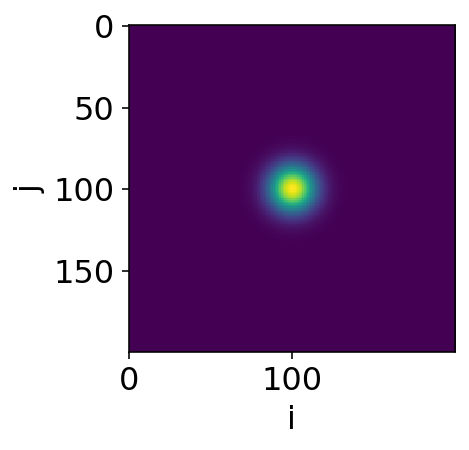

In [4]:
plot_scent_grid(env)

Plot the walk (in grid space)

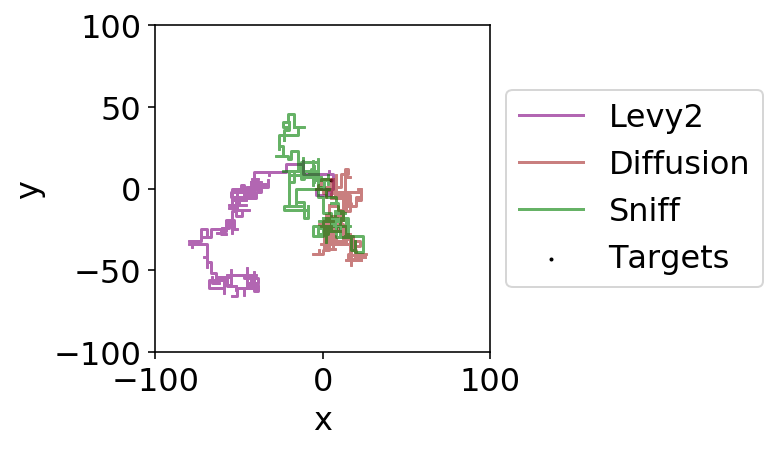

In [5]:
plot_boundary = (100, 100)

num_experiment = 0
ax = plot_position2d(
    select_exp(levy2_exp, num_experiment),
    boundary=plot_boundary,
    label="Levy2",
    color="purple",
    alpha=0.6,
    figsize=(3, 3),
)
ax = plot_position2d(
    select_exp(diff_exp, num_experiment),
    boundary=plot_boundary,
    label="Diffusion",
    color="brown",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(sniff_exp, num_experiment),
    boundary=plot_boundary,
    label="Sniff",
    color="green",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)   

Total reward

In [6]:
print(f'Levy - {np.sum(select_exp(levy2_exp, num_experiment)["exp_reward"])}')
print(f'Diff - {np.sum(select_exp(diff_exp, num_experiment)["exp_reward"])}')
print(f'Sniff - {np.sum(select_exp(sniff_exp, num_experiment)["exp_reward"])}')

Levy - 1
Diff - 2
Sniff - 0


### Question 1.2
In the example above _p pos_ was 0.5, and _p neg_ was 1.0. This means that when the gradient was positive half the time the walker would change direction anyway. It also means the all the time when the grad was negative, the explorer would change direction.

Do these parameter choices seem optimal to you? 

Make a best guess for how to improve them, if you think they can be improved. Explain your choice.

In [15]:
# STUDENT: p pos should always be 1. p neg - I'm not sure
# STUDENT: p pos should always be 0. p neg should be 1

### Question 1.3
Test your hypothesis from Question 1.2. Use total reward as your metric, and the code above to get started. 

_Note:_ Leave the _scent sigma_ parameter value set to 10.

Were you right? 

What is the best set of _p pos_ and _p neg_ that you can find?

test4_sniff: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]
Levy - 6
Diff - 0
Sniff - 59


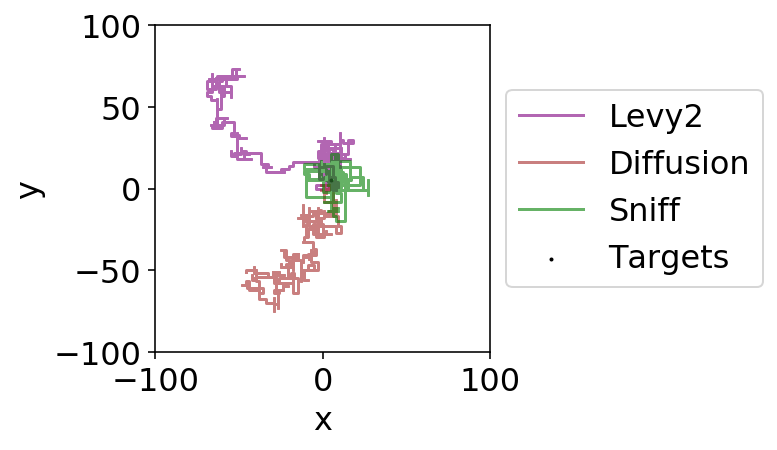

In [14]:
# Experiment settings
num_experiments = 1
num_steps = 1000
p_neg = 1.0
p_pos = 0.0
scent_sigma = 10


# Env
detection_radius = 1
min_length = 1
max_length = 10

env = ScentGrid()
boundary = (100, 100)
target = (5,5)
coord, scent = create_grid_scent(boundary, amplitude=1, sigma=scent_sigma)
env.add_scent(target, 1, coord, scent)
# TODO plot scent

# Agents
diff = DiffusionDiscrete(min_length=min_length, scale=1)
levy2 = TruncatedLevyDiscrete(min_length=min_length, max_length=max_length, exponent=2)
sniff = GradientDiffusionDiscrete(num_actions=4, min_length=min_length, scale=2, p_neg=p_neg, p_pos=p_pos)

# Cleanup 
for path in glob.glob("data/test4_*.pkl"):
    os.remove(path)

# !
levy2_exp = experiment(
    f"data/test4_levy.pkl",
    levy2,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)
diff_exp = experiment(
    f"data/test4_diff.pkl",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)
sniff_exp = experiment(
    f"data/test4_sniff.pkl",
    sniff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)

plot_boundary = (100, 100)

num_experiment = 0
ax = plot_position2d(
    select_exp(levy2_exp, num_experiment),
    boundary=plot_boundary,
    label="Levy2",
    color="purple",
    alpha=0.6,
    figsize=(3, 3),
)
ax = plot_position2d(
    select_exp(diff_exp, num_experiment),
    boundary=plot_boundary,
    label="Diffusion",
    color="brown",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(sniff_exp, num_experiment),
    boundary=plot_boundary,
    label="Sniff",
    color="green",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)   

print(f'Levy - {np.sum(select_exp(levy2_exp, num_experiment)["exp_reward"])}')
print(f'Diff - {np.sum(select_exp(diff_exp, num_experiment)["exp_reward"])}')
print(f'Sniff - {np.sum(select_exp(sniff_exp, num_experiment)["exp_reward"])}')

In [ ]:
# STUDENT p pos = 0.0, p neg = 1 and all other options are worse

### Question 1.4
In Question 1.3 we held _scent sigma_ set to 10. If we vary _scent sigma_ on (1,2,5,10), do you think this will change your best set of _p pos_ and _p neg_? 

Guess first, then test.

In [ ]:
# STUDENT: it should not matter

test4_sniff: 100%|██████████| 1/1 [00:00<00:00,  1.14it/s]
Levy - 7
Diff - 0
Sniff - 59


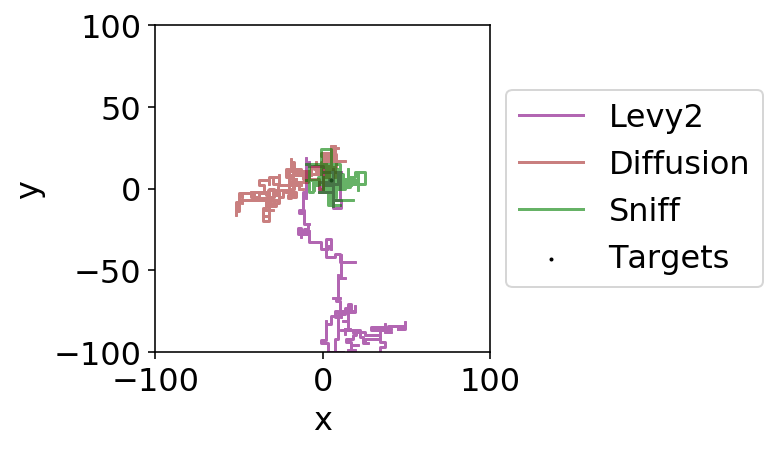

In [21]:
# Sigma = 1
# Experiment settings
num_experiments = 1
num_steps = 1000
p_neg = 1.0
p_pos = 0.0
scent_sigma = 1


# Env
detection_radius = 1
min_length = 1
max_length = 10

env = ScentGrid()
boundary = (100, 100)
target = (5,5)
coord, scent = create_grid_scent(boundary, amplitude=1, sigma=scent_sigma)
env.add_scent(target, 1, coord, scent)
# TODO plot scent

# Agents
diff = DiffusionDiscrete(min_length=min_length, scale=1)
levy2 = TruncatedLevyDiscrete(min_length=min_length, max_length=max_length, exponent=2)
sniff = GradientDiffusionDiscrete(num_actions=4, min_length=min_length, scale=2, p_neg=p_neg, p_pos=p_pos)

# Cleanup 
for path in glob.glob("data/test4_*.pkl"):
    os.remove(path)

# !
levy2_exp = experiment(
    f"data/test4_levy.pkl",
    levy2,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)
diff_exp = experiment(
    f"data/test4_diff.pkl",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)
sniff_exp = experiment(
    f"data/test4_sniff.pkl",
    sniff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)

plot_boundary = (100, 100)

num_experiment = 0
ax = plot_position2d(
    select_exp(levy2_exp, num_experiment),
    boundary=plot_boundary,
    label="Levy2",
    color="purple",
    alpha=0.6,
    figsize=(3, 3),
)
ax = plot_position2d(
    select_exp(diff_exp, num_experiment),
    boundary=plot_boundary,
    label="Diffusion",
    color="brown",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(sniff_exp, num_experiment),
    boundary=plot_boundary,
    label="Sniff",
    color="green",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)   

print(f'Levy - {np.sum(select_exp(levy2_exp, num_experiment)["exp_reward"])}')
print(f'Diff - {np.sum(select_exp(diff_exp, num_experiment)["exp_reward"])}')
print(f'Sniff - {np.sum(select_exp(sniff_exp, num_experiment)["exp_reward"])}')

test4_sniff: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]
Levy - 4
Diff - 0
Sniff - 52


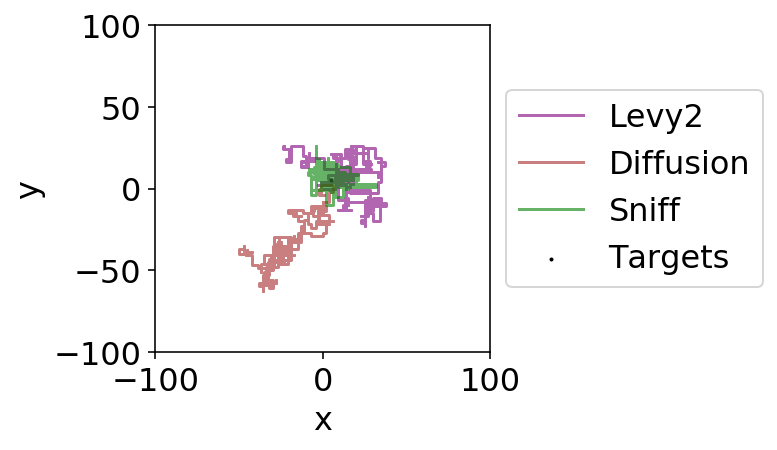

In [23]:
# Sigma = 1
# Experiment settings
num_experiments = 1
num_steps = 1000
p_neg = 1.0
p_pos = 0.0
scent_sigma = 5


# Env
detection_radius = 1
min_length = 1
max_length = 10

env = ScentGrid()
boundary = (100, 100)
target = (5,5)
coord, scent = create_grid_scent(boundary, amplitude=1, sigma=scent_sigma)
env.add_scent(target, 1, coord, scent)
# TODO plot scent

# Agents
diff = DiffusionDiscrete(min_length=min_length, scale=1)
levy2 = TruncatedLevyDiscrete(min_length=min_length, max_length=max_length, exponent=2)
sniff = GradientDiffusionDiscrete(num_actions=4, min_length=min_length, scale=2, p_neg=p_neg, p_pos=p_pos)

# Cleanup 
for path in glob.glob("data/test4_*.pkl"):
    os.remove(path)

# !
levy2_exp = experiment(
    f"data/test4_levy.pkl",
    levy2,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)
diff_exp = experiment(
    f"data/test4_diff.pkl",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)
sniff_exp = experiment(
    f"data/test4_sniff.pkl",
    sniff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)

plot_boundary = (100, 100)

num_experiment = 0
ax = plot_position2d(
    select_exp(levy2_exp, num_experiment),
    boundary=plot_boundary,
    label="Levy2",
    color="purple",
    alpha=0.6,
    figsize=(3, 3),
)
ax = plot_position2d(
    select_exp(diff_exp, num_experiment),
    boundary=plot_boundary,
    label="Diffusion",
    color="brown",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(sniff_exp, num_experiment),
    boundary=plot_boundary,
    label="Sniff",
    color="green",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)   

print(f'Levy - {np.sum(select_exp(levy2_exp, num_experiment)["exp_reward"])}')
print(f'Diff - {np.sum(select_exp(diff_exp, num_experiment)["exp_reward"])}')
print(f'Sniff - {np.sum(select_exp(sniff_exp, num_experiment)["exp_reward"])}')

In [ ]:
# STUDENT - it does not matter for these scent values.

### Question 1.5
Was your hypothesis in Question 1.4 right?

What are the best sets of _p pos_ and _p neg_ you can find for the four _scent sigmas_ in Question 1.4?

In [ ]:
# STUDENT - it does not matter for these scent values.

# COMMENTARY - a mix of perfect deterimism/bias and complete noise leads the best behavoir in this setting. When you get it right, follow the bias. When you get it wrong, uses noise to get yourself out of this pickle? 
#
# Is this a deep lesson?

## Section 2 - a-maze-zing 

I have modifed and existing [Maze env](https://github.com/MattChanTK/gym-maze) to have a scent. Here is an example of it, as a gif.

![Maze](https://camo.githubusercontent.com/0ddf75894c1afc047b54188c958c9eb6967b8b4d1148b95aae918113420a45ad/687474703a2f2f692e67697068792e636f6d2f417233614b786b4141683379302e676966)

The agent starts at the top (red), and tries to find the exit (blue) in the bottom right. In our version we can add a scent field to the exit. This can help our sniffer solve the maze more quickly, or at least that is what we guess should happen in principle.

### Example - one maze experiment

In [40]:
# Experiment settings
num_experiments = 1
num_steps = 100000
p_neg = 1.0
p_pos = 0.0
# p_neg = 1
# p_pos = 0.5
scent_sigma = 5

# Env
detection_radius = 1
min_length = 1
max_length = 10

# Env
boundary = (10, 10)
env = ScentMazeEnv(maze_size=boundary)
coord, scent = create_maze_scent(boundary, amplitude=1, sigma=scent_sigma)
env.add_scent(scent)

# Agents
diff = DiffusionDiscrete(num_actions=4, min_length=min_length, scale=1)
levy2 = TruncatedLevyDiscrete(num_actions=4, min_length=min_length, max_length=max_length, exponent=2)
sniff = GradientDiffusionDiscrete(num_actions=4, min_length=min_length, scale=2, p_neg=p_neg, p_pos=p_pos)

# Cleanup 
for path in glob.glob("data/test4_*.pkl"):
    os.remove(path)

# !
levy2_exp = experiment(
    f"data/test4_levy.pkl",
    levy2,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)
diff_exp = experiment(
    f"data/test4_diff.pkl",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)
sniff_exp = experiment(
    f"data/test4_sniff.pkl",
    sniff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
)

test4_sniff: 100%|██████████| 1/1 [00:11<00:00, 11.70s/it]


Plot the experiment. 

_Note_: unfortunately out standard plotting methods “flip” the axis when displaying the maze. So it looks like we begin at the middle, and finish at the top right. Don't let this distract you. Nothing important has changed.

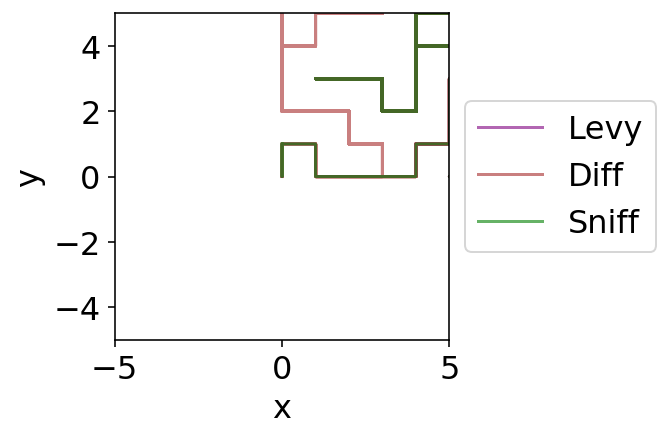

In [41]:
plot_boundary = (5, 5)

num_experiment = 0
ax = plot_position2d(
    select_exp(levy2_exp, num_experiment),
    boundary=plot_boundary,
    label="Levy",
    color="purple",
    alpha=0.6,
    figsize=(3, 3),
)
ax = plot_position2d(
    select_exp(diff_exp, num_experiment),
    boundary=plot_boundary,
    label="Diff",
    color="brown",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(sniff_exp, num_experiment),
    boundary=plot_boundary,
    label="Sniff",
    color="green",
    alpha=0.6,
    ax=ax,
)

Total reward

_Note_: Postive values are good. Negative values bad. If you can't get positive values, try increasing _num steps_.

In [44]:
print(f'Levy - {np.sum(select_exp(levy2_exp, num_experiment)["exp_reward"])}')
print(f'Diff - {np.sum(select_exp(diff_exp, num_experiment)["exp_reward"])}')
print(f'Sniff - {np.sum(select_exp(sniff_exp, num_experiment)["exp_reward"])}')

Levy - [-99.99900000000008]
Levy - [-99.99900000000008]
Levy - [-99.99900000000008]


### Question 2.1

If we set _scent sigma_ to 5 for the maze, do you think the best _p pos_ and _p neg_ that you found in Question 1.5 will be best for the maze task? 

Why?

In [ ]:
# STUDENT: yes, the scent should guide them in
# STUDENT: no, the scent can be a misleading cue when the best way to solve the maze is to walk away from the goal for a few steps

### Question 2.2

Do you think that *any* value of _p pos_ and _p neg_ will cause the sniffer to outperform the other two explorers (Levy and Diffusion)? Explain your answer.

In [ ]:
# STUDENT: the smell should alwayss be an advanatage. It's a hint the random walkers do not have
#          so as long as the p are less than 1.0 it should win. If p is 1, then the sniffer is a 
#          random walker?

# STUDENT: as long a p neg is greater than 0
# STUDENT: as long a p neg is greater than 0.5?

### Question 2.3
To find an approximate answer to Question 2.2, run 100 experiments with three sets of _p pos_ and _p neg_ values. But first, explain your choice for each.

In [ ]:
# STUDENT - presents clear rationals

# COMENTARY - I would have chosen
# p_neg = 1.0
# p_pos = 0.0

# p_neg = 0.5
# p_pos = 0.5

# p_neg = 1.0
# p_pos = 1.0

# or

# p_neg = 0.01
# p_pos = 0.99

# because the nicely span the space of extreme values

In [ ]:
# Write your code here

In [ ]:
# Analysis helper code:

# Results, names, and colors
results = [levy2_exp, diff_exp, sniff_exp]
names = ["Levy", "Diff", "Sniff"]
colors = ["purple", "brown", "green"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

In [ ]:
# Dists
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=20)
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

In [ ]:
# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Score")
plt.tight_layout()
sns.despine()